In [4]:
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans
import matplotlib.pyplot as plt

from pandas import read_csv

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS

from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories

['c:\\Users\\jz421\\Desktop\\GlobalLocal', 'C:\\Users\\jz421\\Desktop\\GlobalLocal\\IEEG_Pipelines', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\python311.zip', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\DLLs', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg', '', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\L

In [10]:
def get_baseline(inst: mne.io.BaseRaw, base_times: tuple[float, float]):
    inst = inst.copy()
    inst.load_data()
    ch_type = inst.get_channel_types(only_data_chs=True)[0]
    inst.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
    trials = trial_ieeg(inst, "experimentStart", adjusted_base_times,
                        preload=True)
    # outliers_to_nan(trials, outliers=10)
    HG_base = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_base, "0.5s")
    del inst
    return HG_base

In [11]:
subjects = ['D0057', 'D0059', 'D0063', 'D0065', 'D0069', 'D0071']

for sub in subjects:
    sub = sub
    task = 'GlobalLocal'
    output_name = "RSA"
    events = ["Stimulus/i25/s75","Stimulus/i75/s75", "Stimulus/c25/s75","Stimulus/c75/s75"] #might have to list all of the events here???
    times = (0, 0.5)
    base_times = (1, 101)
    LAB_root = None
    channels = None

    if LAB_root is None:
        HOME = os.path.expanduser("~")
        if os.name == 'nt':  # windows
            LAB_root = os.path.join(HOME, "Box", "CoganLab")
        else:  # mac
            LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                    "CoganLab")

    layout = get_data(task, root=LAB_root)
    filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                        extension='.edf', desc='clean', preload=False)
    save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    ###

    good = crop_empty_data(filt)
    # %%

    print(f"good channels before dropping bads: {len(good.ch_names)}")
    print(f"filt channels before dropping bads: {len(filt.ch_names)}")

    good.info['bads'] = channel_outlier_marker(good, 3, 2)
    print("Bad channels in 'good':", good.info['bads'])

    filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
    good.drop_channels(good.info['bads'])

    print("Bad channels in 'good' after dropping once:", good.info['bads'])

    print(f"good channels after dropping bads: {len(good.ch_names)}")
    print(f"filt channels after dropping bads: {len(filt.ch_names)}")

    HG_base = get_baseline(filt, base_times)
    good.load_data()

    # If channels is None, use all channels
    if channels is None:
        channels = good.ch_names
    else:
        # Validate the provided channels
        invalid_channels = [ch for ch in channels if ch not in good.ch_names]
        if invalid_channels:
            raise ValueError(
                f"The following channels are not valid: {invalid_channels}")

        # Use only the specified channels
        good.pick_channels(channels)

    ch_type = filt.get_channel_types(only_data_chs=True)[0]
    good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    # events = mne.find_events(good, min_duration=0.002) #get all events except experimentStart

    all_epochs_list = []

    for event in events:
    # Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
        times_adj = [times[0] - 0.5, times[1] + 0.5]
        trials = trial_ieeg(good, event, times_adj, preload=True,
                            reject_by_annotation=False)
        all_epochs_list.append(trials)

    # Concatenate all trials
    all_trials = mne.concatenate_epochs(all_epochs_list)

    outliers_to_nan(all_trials, outliers=10)
    HG_ev1 = gamma.extract(all_trials, copy=False, n_jobs=1)
    crop_pad(HG_ev1, "0.5s")
    HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

    HG_base.decimate(2)
    HG_ev1.decimate(2)
    RTs, skipped = calculate_RTs(good)
    avg_RT = np.median(RTs)

    HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0))
    HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_ieeg.edf...
EDF file detected
Setting channel info str

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 178
filt channels before dropping bads: 178
outlier round 1 channels: ['RAMT8']
outlier round 2 channels: ['RAMT8', 'RPI16']
outlier round 2 channels: ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good': ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 175
filt channels after dropping bads: 175
Reading 0 ... 8243199  =      0.000 ...  4025.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus

100%|██████████| 1/1 [01:01<00:00, 61.57s/it]


Reading 0 ... 5983997  =      0.000 ...  2921.874 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
22 matching events foun

C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
166 matching events found
No baseline correction applied


100%|██████████| 166/166 [02:51<00:00,  1.03s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:85: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:86: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 184
filt channels before dropping bads: 184
outlier round 1 channels: ['LMPF15']
outlier round 2 channels: ['LMPF15', 'LASP3']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good': ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 178
filt channels after dropping bads: 178
Reading 0 ... 8769535  =      0.000 ...  4282.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', '

100%|██████████| 1/1 [01:31<00:00, 91.97s/it]


Reading 0 ... 6582517  =      0.000 ...  3214.120 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/n75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
22 

C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
166 matching events found
No baseline correction applied


100%|██████████| 166/166 [01:54<00:00,  1.45it/s]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:85: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:86: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 227 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 220 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 240
filt channels before dropping bads: 240
outlier round 1 channels: ['LOF16']
outlier round 1 channels: ['LOF16', 'RMMT14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good': ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 234
filt channels after dropping bads: 234
Reading 0 ... 4386815  =      0.000 ...  2142.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Resp

100%|██████████| 1/1 [01:23<00:00, 83.86s/it]


Reading 0 ... 3925799  =      0.000 ...  1916.894 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
22 

C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
166 matching events found
No baseline correction applied


100%|██████████| 166/166 [03:28<00:00,  1.26s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:85: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:86: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 217 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 222 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 220
filt channels before dropping bads: 220
outlier round 1 channels: ['RPIF3']
outlier round 1 channels: ['RPIF3', 'RAIO9']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good': ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 216
filt channels after dropping bads: 216
Reading 0 ... 6350847  =      0.000 ...  3101.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s2

100%|██████████| 1/1 [02:43<00:00, 163.81s/it]


Reading 0 ... 5705315  =      0.000 ...  2785.798 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
22 

C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
166 matching events found
No baseline correction applied


100%|██████████| 166/166 [02:18<00:00,  1.20it/s]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:85: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:86: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 214 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 132
filt channels before dropping bads: 132
outlier round 1 channels: ['LTMS11']
outlier round 2 channels: ['LTMS11', 'LTAS9']
Bad channels in 'good': ['LTMS11', 'LTAS9']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 130
filt channels after dropping bads: 130
Reading 0 ... 5701631  =      0.000 ...  2784.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c

100%|██████████| 1/1 [00:44<00:00, 44.53s/it]


Reading 0 ... 5221780  =      0.000 ...  2549.697 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
21 

C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)
100%|██████████| 166/166 [01:19<00:00,  2.09it/s]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:85: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:86: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 162
filt channels before dropping bads: 162
outlier round 1 channels: ['RTAS7']
outlier round 1 channels: ['RTAS7', 'RTMM15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good': ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 157
filt channels after dropping bads: 157
Reading 0 ... 6021119  =      0.000 ...  2940.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i

100%|██████████| 1/1 [00:54<00:00, 54.98s/it]


Reading 0 ... 4864645  =      0.000 ...  2375.315 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
22 

C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


166 matching events found
No baseline correction applied


100%|██████████| 166/166 [01:35<00:00,  1.73it/s]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:85: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3671923162.py:86: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [37]:
# example code from https://mne.tools/stable/auto_examples/decoding/decoding_rsa_sgskip.html

# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.
clf = make_pipeline(
    StandardScaler(), LogisticRegression(C=1, solver="liblinear", multi_class="auto")
)

epochs = HG_ev1_rescaled #im not sure if this is right..this is averaged over trials. The mne demo then averages across time??? 
# X = epochs.copy().crop(0, 0.5).get_data()
# X = np.nanmean(X, axis=2)
X = epochs.get_data().mean(axis=2)
X[np.isnan(X)] = 0 #this is totally bullshit, cant just set all the nans to 0 but do this for testing...
y = epochs.events[:, 2]

classes = set(y)
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

# Compute confusion matrix for each cross-validation fold
y_pred = np.zeros((len(y), len(classes)))
for train, test in cv.split(X, y):
    # Fit
    clf.fit(X[train], y[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict_proba(X[test])

In [38]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (24).

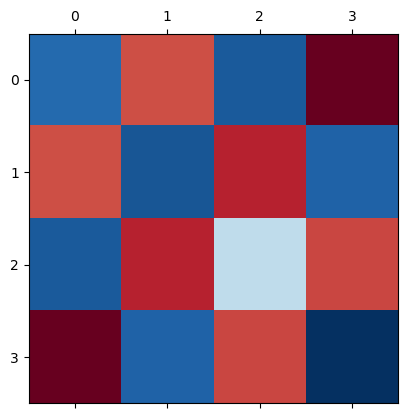

In [39]:
labels = [""] * 5 + ["face"] + [""] * 11 + ["bodypart"] + [""] * 6
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap="RdBu_r", clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha="left")
ax.axhline(11.5, color="k")
ax.axvline(11.5, color="k")
plt.colorbar(im)
plt.tight_layout()
plt.show()

c:\Users\jz421\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


NameError: name 'conds' is not defined

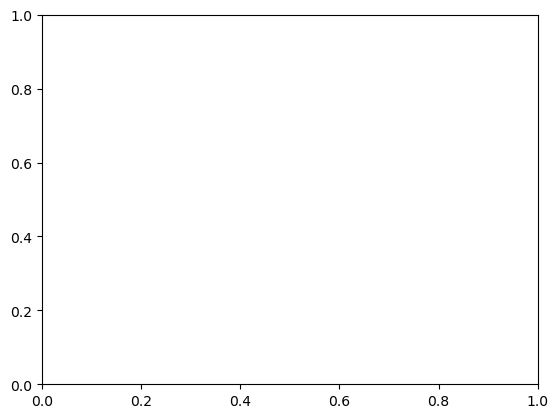

In [40]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity="precomputed")
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.colormaps["rainbow"]
colors = ["r", "b"]
names = list(conds["condition"].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == "human face" else 100
    ax.scatter(
        summary[sel, 0],
        summary[sel, 1],
        s=size,
        facecolors=color,
        label=name,
        edgecolors="k",
    )
ax.axis("off")
ax.legend(loc="lower right", scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()

### just try with scipy instead???

In [44]:
activity_patterns.get_data().shape

(166, 157, 1025)

In [50]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

time_window = (0, 0.5)  # Example time window

activity_patterns = HG_ev1_rescaled.copy().crop(tmin=time_window[0], tmax=time_window[1])
avg_activity_patterns = np.nanmean(activity_patterns.get_data(), axis=2)

# Compute pairwise dissimilarity (1 - correlation) for each pair of conditions
dissimilarities = pdist(avg_activity_patterns, metric='correlation')
rdm = squareform(dissimilarities)

C:\Users\jz421\AppData\Local\Temp\ipykernel_10536\3993670347.py:7: RuntimeWarning: Mean of empty slice
  avg_activity_patterns = np.nanmean(activity_patterns.get_data(), axis=2)


In [51]:
rdm

array([[0.        , 1.28480101, 0.64692671, ...,        nan,        nan,
               nan],
       [1.28480101, 0.        , 1.25869734, ...,        nan,        nan,
               nan],
       [0.64692671, 1.25869734, 0.        , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.        ,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan, 0.        ,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.        ]])